In [12]:
#!/usr/bin/env python
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import rcParams
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import xarray as xr 

In [13]:

CONFIG='CREG12.L75'
CASE='REF08'
main_dir='/data0/project/drakkar/CONFIGS/'


In [14]:
def nemo_Arc_plot(lon,lat,tab,contours,limits,myticks=None,name=None,zmy_cblab=None,zmy_cmap=None,filename='test.pdf',zvar=None):

    plt.figure(figsize=(20,15))
    rcParams['font.family']='serif'
    plt.rcParams['contour.negative_linestyle'] = 'solid'
    #
    #tab=PyRaf.limit_range(tab,limits[0],limits[1])
    # background
    m = Basemap(projection='npstere',boundinglat=65,lon_0=-20., resolution='i')
    if zvar != 'Bathy' :
        m.drawparallels(np.arange(-90.,91.,5.),labels=[False,False,False,False])
        m.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True])
        m.fillcontinents(color='grey',lake_color='white')
    # contour filled
    norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])

    if zmy_cmap != None :
        pal = zmy_cmap
    else:
        pal = plt.cm.get_cmap('Spectral')

    X,Y = m(lon,lat)
    C = m.contourf(X,Y,tab,contours,cmap=pal,norm=norm,extend='both')
    CS2 = m.contour(X,Y,tab, linewidths=1., levels=contours, colors='k',alpha=0.8)
    plt.clabel(CS2, CS2.levels, inline=True, fmt='%3.0f', fontsize=12, colors='k')

    ############################################################################################################
    ############################################################################################################
    moorplot=0
    if moorplot == 1 :
        bx_ARCB={'name':'B' ,'lon_min':-150.,'lon_max':-150.,'lat_min':78.,'lat_max':78.}
        bx_ARCM={'name':'M1','lon_min': 125.,'lon_max': 125.,'lat_min':78.,'lat_max':78.}

        All_box=[bx_ARCB,bx_ARCM]
        for box in All_box:
                lats = [box['lat_min'],box['lat_max']]
                lons = [box['lon_min'],box['lon_max']]
                x,y = m(lons,lats)
                m.scatter(x,y,6,marker='o', color='w')
                #m.plot(x,y,linewidth=2, color='g')
    ############################################################################################################
    ############################################################################################################

    plt.title(name,fontsize=11)

    return 

## Compute the diffusivity coef. on the CREG12.L75 

<Figure size 432x288 with 0 Axes>

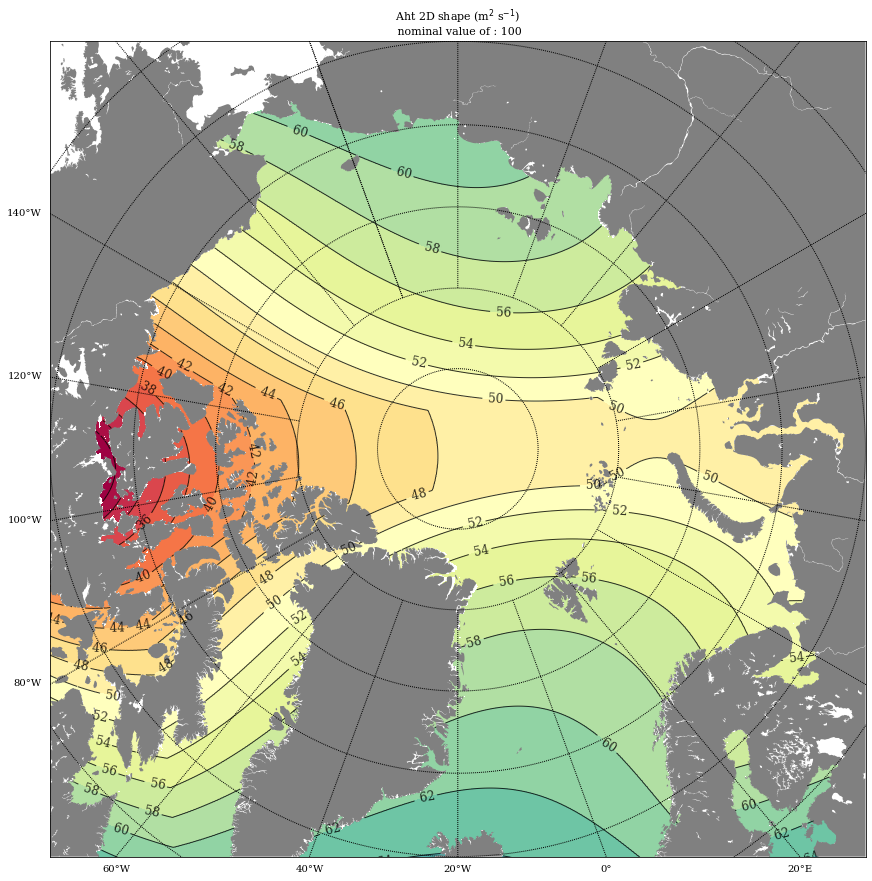

In [22]:
ds_msk=xr.open_dataset(main_dir+CONFIG+'/GRID/'+CONFIG+'_byte_mask.nc')
ds_hgr=xr.open_dataset(main_dir+CONFIG+'/GRID/'+CONFIG+'_mesh_hgr.nc')
ds_coo=xr.open_dataset(main_dir+CONFIG+'/GRID/'+'coordinates_CREG12.L75.nc')

tmask2D=np.ma.squeeze(ds_msk['tmask'].sel(z=0,t=0).copy())

# Nominal value of the tracers diffusions in CREG12.75 (as set in the namelist)
aht0=100.

# Calculation of the difusivity on the grid F°(∆x)
zd_max = np.max(np.array([ ds_hgr['e1t'].sel(t=0).max(), ds_hgr['e2t'].sel(t=0).min() ]))
za00 = aht0 / zd_max
zetmax = np.maximum( ds_hgr['e1t'].sel(t=0), ds_hgr['e2t'].sel(t=0))
aht1 = za00 * zetmax[:,:]

# Apply mask
aht1=np.ma.masked_where(tmask2D == 0, aht1)
#aht1=np.ma.masked_where(ds_msk['nav_lat'] <= 30., aht1)

# Set the contpours, min, max etc ...
vmin=30. ; vmax=72. ; vint=2.
contours=np.arange(vmin,vmax+vint,vint) 
limits=[vmin,vmax]            # limits for psi
myticks=np.arange(vmin,vmax+vint,vint) 
nom_aht=str(np.int(np.ceil(aht0)))
name=''
name=r'Aht 2D shape (m$^{2}$ s$^{-1}$) '+'\n nominal value of : '+nom_aht
filename='aht1_shape'     
my_cblab=''
zMyvar='votemper'

# Do the plot
plt.clf()
nemo_Arc_plot(ds_msk['nav_lon'], ds_msk['nav_lat'], aht1, contours, limits, myticks, name=name, zmy_cblab=my_cblab, zvar=zMyvar)

plt.savefig(CONFIG+'_'+filename+'_aht'+nom_aht+'.pdf',dpi=300)


# Save the result in a Netcdf file
if True: 
    ds_out=xr.Dataset() 
    ds_out['aht_0']=(('y','x'),aht1)
    ds_out.coords['nav_lon']=ds_coo['nav_lon']
    ds_out.coords['nav_lat']=ds_coo['nav_lat']
    ds_out.to_netcdf('CREG12.L75-REF08_aht.nc')
